In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# Programación probabilística (PP)

Nuevo paradigma que busca combinar los lenguajes de programación de propósito general con el modelamiento probabilístico

El objetivo es hacer estadística y en particular inferencia Bayesiana usando las herramientas de ciencias de la computación

Como veremos a continuación la PP corre en dos direcciones:

<a href="https://arxiv.org/abs/1809.10756"><img src="images/PP.png" width="500"></a>

El lenguaje Python tiene un ecosistema rico en frameworks y librerías de PP:

- [PyMC3](https://docs.pymc.io/notebooks/getting_started.html)
- [PyStan](https://pystan.readthedocs.io/en/latest/)
- [Edward](http://edwardlib.org/)
- [Pyro](http://pyro.ai)
- [emcee](http://dfm.io/emcee/current/)


# Tutorial de PyMC3

En este tutorial veremos como

1. Definir un modelo bayesiano en base a una verosimilitud y a un prior
1. Aplicar distintos algoritmos de MCMC sobre el modelo
1. Verificar la convergencia y analizar los posteriors

Usaremos como ejemplo una **regresión lineal Bayesiana**

## Instalación

Usando los canales por defecto de conda instalar usando

    conda install pymc3 theano graphviz python-graphviz
    
Graphviz solo se requiere para algunos gráficos opcionales

Adicionalmente 

    conda install corner -c conda-forge
    
También para hacer algunos gráficos de diagnóstico



## Formulación clásica

Consideramos que tenemos $N$ tuplas $(x_i, y_i)$ donde $X$ es la variable independiente e $Y$ la dependiente

En una regresión queremos estimar $\mathbb{E}[Y|X]$ en base a un modelo paramétrico $Y = f_\theta(X)$

En este caso asumiremos un modelo lineal

$$
y_i = w x_i + b + \epsilon \quad i=1,\ldots,N
$$

donde queremos aprender los parámetros $w$ y $b$ bajo el supuesto de que $p(\epsilon) = \mathcal{N}(0, \sigma^2)$

Luego 

$$
y \sim  \mathcal{N}(b + w x, \sigma^2)
$$

y la verosimilitud sería

$$
p(y|x,w,b,\sigma)  = \prod_{i=1}^N \mathcal{N}(b + w x_i, \sigma^2)
$$


## Imports y creación de datos 

PyMC3 ver: 3.8


<IPython.core.display.Javascript object>


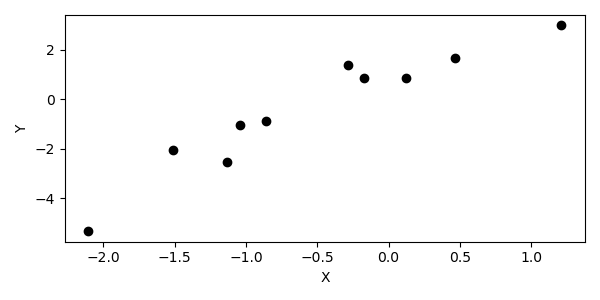

In [2]:
import pymc3 as pm
print(f'PyMC3 ver: {pm.__version__}')
import theano.tensor as T

np.random.seed(123456)
b_star, w_star, sigma_star, N = 1, 2.5, 1., 10
X = np.random.randn(N)
Y = mu_star + w_star*X +  np.random.randn(N)*sigma_star

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.scatter(X, Y, c='k')
ax.set_xlabel('X'); ax.set_ylabel('Y'); 

## Formulación bayesiana

A diferencia de una regresión "convencional" asumiremos que $w$, $b$ y $\sigma$ no son variables deterministas sino **aleatorias** y por ende **tienen distribuciones**

<img src="images/lin_reg_plate.png" width="700">


Lo que buscamos es el posterior de los parámetros, en este caso usando el Teorema de Bayes

$$
p(w, b, \sigma|D) = \frac{p(D|w, b, \sigma) p(w) p(b) p(\sigma)}{\int p(D|w, b, \sigma) p(w) p(b) p(\sigma) dw db d\sigma}
$$

donde $D$ representa los datos $(x, y)$ y por simplicidad el prior se puede factorizar

Para obtener muestras de este posterior usaremos MCMC


## Especificación del modelo generativo en PyMC3

El modelo generativo es aquel que "produjo" los datos

Usualmente parte en los hiperparámetros, continua en las variables latentes (priors) y termina en las variables observadas (verosimilitud)

En PyMC3 los modelos se deben crear dentro de un contexto `pm.Model()`

Dentro de este contexto definimos los priors, la verosimilitud y cualquier otra variable auxiliar


In [18]:
with pm.Model() as bayes_reg:
    # Datos de entrada
    X_shared = pm.Data("x", X)
    # Priors
    b = pm.Normal(name='b', mu=0, sd=10, shape=())
    w = pm.Normal(name='w', mu=0, sd=10, shape=())
    sigma = pm.Lognormal('sigma', sigma=1, testval=np.std(Y))
    # Variable determinista
    mu = pm.Deterministic('mu', b + X_shared*w)  
    # Verosimilitud
    Y_obs = pm.Normal('Y_obs', mu, sigma, observed=Y)


### Creando variables aleatorias

Para crear una variable aleatoria debemos primero seleccionar una distribución por ejemplo `Normal`, `Bernoulli`, etc

El constructor debe especificar el nombre propio de la variable (primer argument) y los parámetros de la distribución

Opcionalmente se puede proporcional el valor inicial de la variable aleatoria con `testval` y la dimensionalidad de la variable aleatoria con `shape`

We have set two stochastic variables with normal and half normal distributions, respectively

La lista completa de distribuciones la pueden revisar [aquí](https://docs.pymc.io/api/distributions.html)

### Especificando la verosimilitud

La verosimilitud se crea igual que una variable aleatoria pero agregando el argumento `observed`

A este argumento debemos proporcionarle los datos en formato `ndarray` de NumPy o `DataFrame` de pandas

### Jerarquía

Note como usamos variables aleatorias como parámetros para otras variables aleatorias

El modelo toma nota de esto y crea relaciones padre-hijo entre los nodos

[b, w, sigma_log__]

[sigma, mu]

[Y_obs]

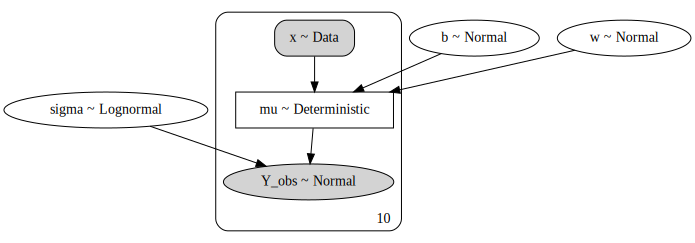

In [4]:
display(bayes_reg.free_RVs, 
        bayes_reg.deterministics, 
        bayes_reg.observed_RVs)

display(bayes_reg)

pm.model_to_graphviz(bayes_reg)

## ¿Qué genera nuestro modelo?

Un primer diagnóstico para asegurarnos de que nuestro modelo hace lo que queremos que haga es observar las muetras que están generando

Podemos muestrear desde los priors usando la función `pm.sample_prior_predictive`

<IPython.core.display.Javascript object>


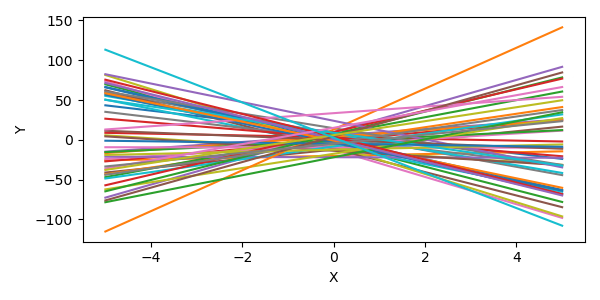

In [5]:
x_test = np.linspace(-5, 5, num=100)

with bayes_reg:
    prior_checks = pm.sample_prior_predictive(samples=50, var_names=['w', 'b'])
    
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.set_xlabel('X'); ax.set_ylabel('Y'); 

for w, b in zip(prior_checks['w'], prior_checks['b']):
    ax.plot(x_test, x_test*w + b)

## MCMC con PyMC3

La maquinaria de MCMC en PyMC3 se accede usando la función 

```python
pm.sample(draws=500, # Largo de la traza (posterior a burn-in)
          step=None, # Algoritmo de propuestas
          chains=None, # Número de cadenas
          cores=None, # Número de núcleos de CPU
          tune=500, # Número de pasos de burn-in
          init='auto', # Algoritmo de inicialización 
          n_init=200000, # Número de iteraciones del algoritmo de inicialización
          start=None, # Diccionario con valores iniciales para las RV 
          ...
          )
```

El largo de la traza y la cantidad de iteraciones de *burn-in* debemos afinarlas iterativamente inspeccionando las trazas y las divergencias de la cadena. Más es siempre mejor pero también más lento

Es recomendable usar dos o más cadenas en paralelo, así podemos verificar con mayor certeza la convergencia

El argumento `step` define el algoritmo de propuestas. Podemos usar un mismo algoritmo para todos los parámetros o usar uno distinto para cada uno. Entre los algoritmos se [encuentran](https://docs.pymc.io/api/inference.html#step-methods) 

- `pm.Metropolis()`: Metropolis Hastings, el cual ya hemos visto en detalle. Es la opción por defecto para variables discretas
- `pm.NUTS()`: [No U-turn Sampler](https://arxiv.org/abs/1111.4246), un *sampler* de tipo Hamiltoniano. Es la opción por defecto para variables continuas

El punto de partida de la cadena es muy relevante. Está la opción de entregar valores manualmente con el argumento `start` o usar un método automático y más económico que MCMC, por defecto se inicializa con una heurística que depende de cada *sampler*

## (Breve intermedio teórico) Hamiltonian Monte Carlo

Es una familia de métodos de propuesta que usan información de la derivada de la densidad de la cual estamos muestreando para hacer transiciones más eficientes. Por ende sólo funcionan con parámetros continuos y derivables

Cada iteración es más costosa con respecto a Metropolis-Hastings, pero en general se requieren menos iteraciones ya que converge más rápido al estado estacionario

Revisemos los siguientes [ejemplos animados](http://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html). [Más detalles](https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html)  del algoritmo [HMC original](https://arxiv.org/abs/1312.0906)


## Obteniendo muestras con `pm.sample`

De vuelta a nuestro problema, veamos como cambian los resultados con distintos *samplers* y largos de traza

In [23]:
with pm.Model() as bayes_reg:
    # Datos de entrada
    X_shared = pm.Data("x", X)
    # Priors
    b = pm.Normal(name='b', mu=0, sd=10, shape=())
    w = pm.Normal(name='w', mu=0, sd=10, shape=())
    sigma = pm.Lognormal('sigma', sigma=1, testval=np.std(Y))
    # Variable determinista
    mu = pm.Deterministic('mu', b + X_shared*w)  
    # Verosimilitud
    Y_obs = pm.Normal('Y_obs', mu, sigma, observed=Y)

    
with bayes_reg:
    trace = pm.sample(draws=200, tune=0, chains=2, cores=2,
                      step=pm.Metropolis())

Only 200 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [w]
>Metropolis: [b]
Sampling 2 chains, 0 divergences: 100%|██████████| 400/400 [00:00<00:00, 6845.13draws/s]
The number of effective samples is smaller than 10% for some parameters.


## Diagnósticos visuales y numéricos

Podemos visualizar los posteriors y las trazas con `traceplot`

<IPython.core.display.Javascript object>


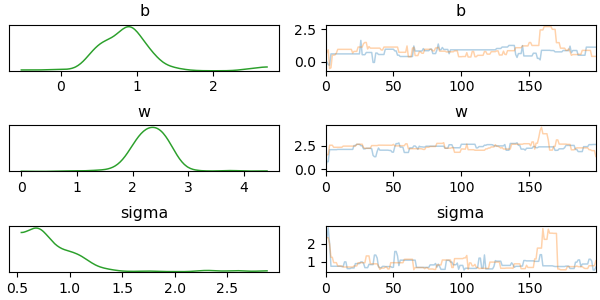

/home/phuijse/.conda/envs/info183/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/phuijse/.conda/envs/info183/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/phuijse/.conda/envs/info183/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


In [24]:
pm.traceplot(trace, figsize=(6, 3), var_names=['b', 'w', 'sigma'], combined=True);

Si sólo nos interesan los posteriors y sus descriptores podemos usar `plot_posterior`

<IPython.core.display.Javascript object>


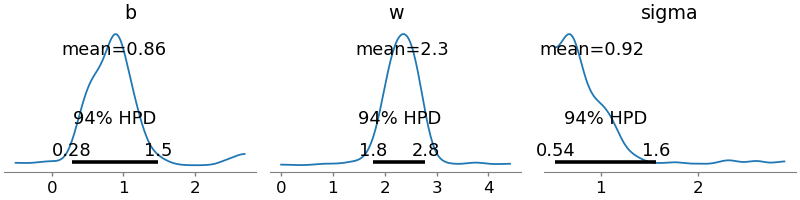

In [25]:
pm.plot_posterior(trace, figsize=(8, 2), var_names=['b', 'w', 'sigma'], textsize=12);

O un resumen tabular de lo anterior:

In [26]:
pm.summary(trace, var_names=['b', 'w', 'sigma']).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,0.86,0.42,0.28,1.49,0.08,0.06,26.0,26.0,28.0,31.0,1.03
w,2.34,0.38,1.77,2.79,0.06,0.05,36.0,35.0,34.0,39.0,1.05
sigma,0.92,0.41,0.54,1.57,0.06,0.04,51.0,47.0,76.0,53.0,1.02


Donde $\hat r$ es el estadístico Gelman Rubin 

- Se compara la varianza entre múltiples cadenas con la varianza interna de cada cadena
- Valores mayores que uno indican que una o más cadenas aun no han convergido


Finalmente podemos estudiar convergencia usando la función de autocorrelación para cada parámetro y cada cadena como vimos en la lección anterior

<IPython.core.display.Javascript object>


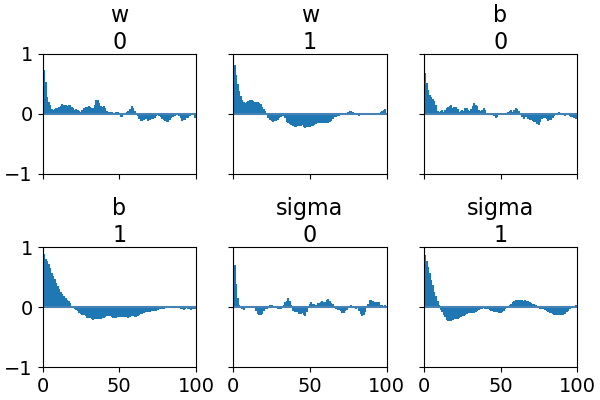

In [28]:
pm.plots.autocorrplot(trace, figsize=(6, 4), 
                      var_names=['w', 'b', 'sigma']);

También podemos visualizar las correlaciones en el posterior 

<IPython.core.display.Javascript object>


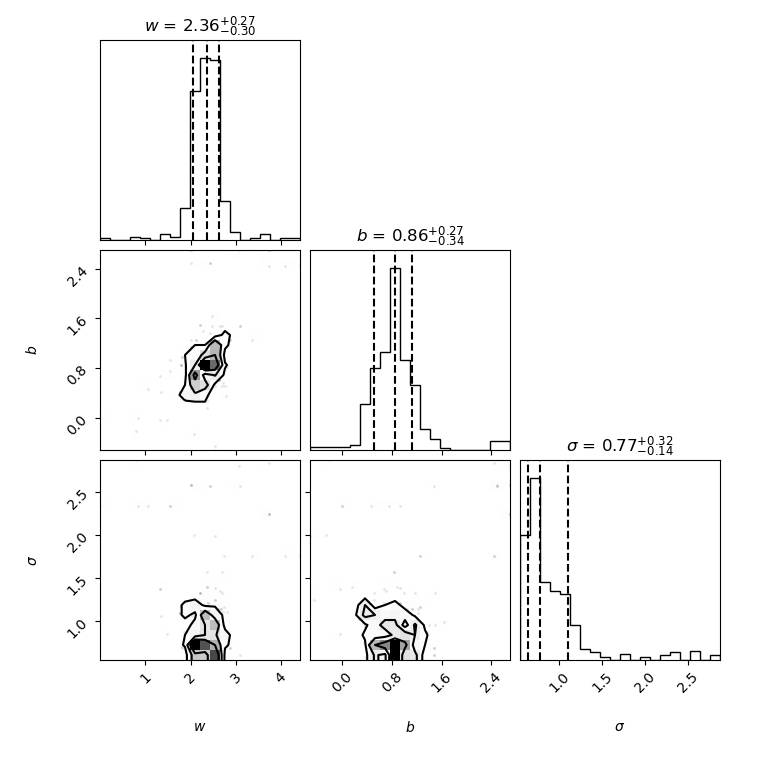

In [27]:
from corner import corner
samples = np.vstack([trace[k] for k in ["w", "b", "sigma"]]).T
corner(samples, quantiles=[0.16, 0.5, 0.84],
       labels=[r"$w$", r"$b$", r"$\sigma$"],
       show_titles=True, title_kwargs={"fontsize": 12});

## Distribución posterior predictiva

Ahora que tenemos el posterior de los parámetros podemos usarlo para calcular la distribución posterior predictiva en función de un nuevo dato $\textbf{x}$

$$
p(\textbf{y}|\textbf{x}, \mathcal{D}) = \int p(\textbf{y}|\textbf{x},\theta) p(\theta| \mathcal{D}) \,d\theta 
$$

donde en este caso $\theta = (w, b, \sigma)$ y se asume que $y$ es condicionalmente independiente de  $\mathcal{D}$ dado que conozco $\theta$

La parte más difícil era estimar $p(\theta| \mathcal{D})$ el cual ya tenemos. Para obtener las muestras del posterior predictivo podemos usar nuestra traza con la función `pm.sample_posterior_predictive`

Note como se actualiza la variable compartida `x` para que refleje los datos de prueba que queremos predecir

In [14]:
x_test = np.linspace(-5, 5, num=100)

with bayes_reg:
    pm.set_data({"x": x_test})
    posterior_predictive = pm.sample_posterior_predictive(trace, samples=100, 
                                                          var_names=["mu", "Y_obs"])

/home/phuijse/.conda/envs/info183/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 599.80it/s]


<IPython.core.display.Javascript object>


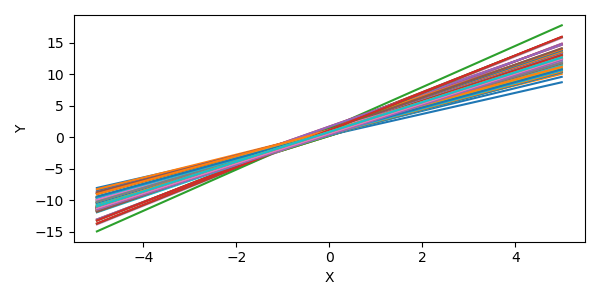

In [15]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.set_xlabel('X'); ax.set_ylabel('Y'); 

for line in posterior_predictive["mu"]:
    ax.plot(x_test, line)

<IPython.core.display.Javascript object>


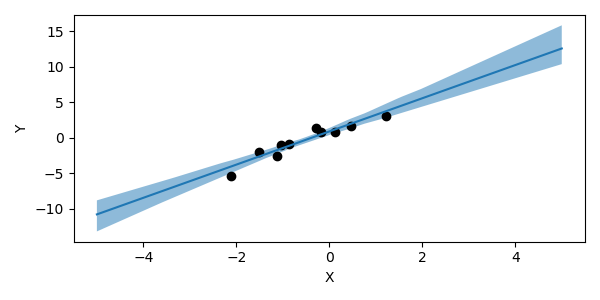

In [16]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.set_xlabel('X'); ax.set_ylabel('Y'); 

mean = np.mean(posterior_predictive["mu"], axis=0)
perc = np.percentile(posterior_predictive["mu"], q=(5, 95), axis=0)

ax.plot(x_test, mean)
ax.fill_between(x_test, perc[1], perc[0], alpha=0.5)
ax.scatter(X, Y, c='k')
ax.set_xlabel('X'); ax.set_ylabel('Y');